In [21]:
import os
import numpy as np
import pandas as pd
from nilearn import masking, image
from scipy.stats import ttest_1samp,ttest_rel
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from misc.cohensd import cohensd,cohens_d_onesample

sns.set_style('white')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

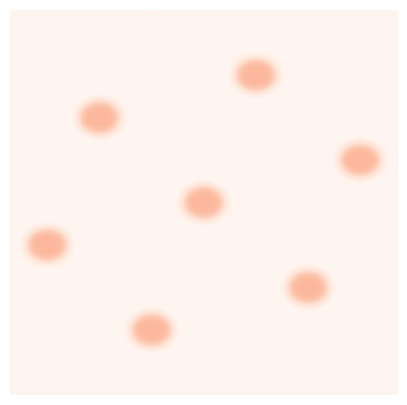

In [2]:
import seaborn as sns
from scipy.ndimage import gaussian_filter


def firing_pattern(x, y, scale, field_radius, orientation):
    # Create a hexagonal grid of firing field centers
    x_coords = np.arange(-scale, scale + 1)
    y_coords = np.arange(-scale, scale + 1)
    xx, yy = np.meshgrid(x_coords, y_coords)
    centers = np.column_stack((xx.flatten(), yy.flatten())).astype(np.float64) * scale
    centers[:, 0] += 0.5 * (centers[:, 1] % 2) * scale

    # Apply the rotation matrix to the centers
    rotation_matrix = np.array([[np.cos(orientation), -np.sin(orientation)],
                                [np.sin(orientation), np.cos(orientation)]])
    centers = centers @ rotation_matrix

    # Calculate the firing rate at each (x, y) position
    firing_rate = np.zeros_like(x)
    for center in centers:
        distance = np.sqrt((x - center[0]) ** 2 + (y - center[1]) ** 2)
        firing_rate += np.exp(-distance ** 2 / (2 * field_radius ** 2))
    return firing_rate


# Define the parameters for the grid cell
scale = 5
field_radius = 0.55
orientation = np.pi / 4  # 30 degrees

# Create a grid of x and y coordinates
x = np.linspace(-scale*1.6*0.82 ,scale*1.6*0.82, 1000)
y = np.linspace(-scale*1.6, scale*1.6, 1000)
xx, yy = np.meshgrid(x, y)

# Compute the firing pattern of the grid cell
firing_rate = firing_pattern(xx, yy, scale, field_radius, orientation)

# # Define the radius of the circular mask
radius = 600

# Create a meshgrid of the same size as firing_rate
xx, yy = np.meshgrid(np.arange(firing_rate.shape[0]), np.arange(firing_rate.shape[1]))

# Calculate the distance from the center of the grid to each point
distance = np.sqrt((xx - firing_rate.shape[0] / 2) ** 2 + (yy - firing_rate.shape[1] / 2) ** 2)

# Create a circular mask
mask = np.zeros_like(firing_rate)
mask[distance <= radius] = 1

# Apply the mask to the firing rate
masked_firing_rate = firing_rate * mask

# Apply Gaussian smoothing to the firing rate data
sigma = 10
#masked_firing_rate[masked_firing_rate<0.5]=0
masked_firing_rate[masked_firing_rate>0.5]=masked_firing_rate.max()*0.8
smoothed_firing_rate = gaussian_filter(masked_firing_rate, sigma)

# Plot the firing pattern
fig, ax = plt.subplots(figsize=(5, 5))
#plt.imshow(normalized_smoothed_firing_rate, cmap="gray", origin="lower")
plt.pcolormesh(x,y,smoothed_firing_rate ,cmap='Reds', vmax=2.5, vmin=0.2)
# Remove the borde2
for spine in ax.spines.values():
    spine.set_visible(False)
    spine.set_linewidth(3)
#sns.heatmap(normalized_smoothed_firing_rate,cmap='get')
plt.gca().set_xticks([])
plt.gca().set_yticks([])
#plt.savefig("/mnt/workdir/DCM/Result/paper/figure2/firing_pattern_Reds_narrow.png", dpi=300, bbox_inches='tight', transparent=True,pad_inches=0)
plt.show()

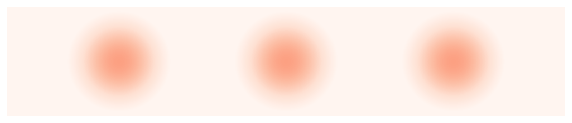

In [254]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

def firing_pattern(x, y, n_centers, center_distance, field_radius):
    # Create a linear array of firing field centers
    total_distance = (n_centers - 1) * center_distance
    centers = np.linspace(-total_distance / 2, total_distance / 2, n_centers)[:, np.newaxis]

    # Calculate the firing rate at each (x, y) position
    firing_rate = np.zeros_like(x)
    for center in centers:
        distance = np.sqrt((x - center[0]) ** 2 + y ** 2)
        firing_rate += np.exp(-distance ** 2 / (2 * field_radius ** 2))
    return firing_rate

# Define the parameters for the grid cell
n_centers = 1
center_distance = 3  # adjust this value as needed
field_radius = 0.6

# Create a grid of x and y coordinates
x = np.linspace(-5, 5, 1000)
y = np.linspace(-1, 1, 1000)
xx, yy = np.meshgrid(x, y)

# Compute the firing pattern of the grid cell
firing_rate = firing_pattern(xx, yy, n_centers, center_distance, field_radius)

# Apply Gaussian smoothing to the firing rate data
sigma = 10
smoothed_firing_rate = gaussian_filter(firing_rate, sigma)

# Normalization function
def normalize_data(data, min_value, max_value):
    normalized_data = (data - np.min(data)) / (np.max(data) - np.min(data))
    return normalized_data * (max_value - min_value) + min_value

# Plot the firing pattern
fig, ax = plt.subplots(figsize=(10, 2))
plt.pcolormesh(x, y, firing_rate, cmap='Reds', shading='auto', vmax=2.4, vmin=0.3)

for spine in ax.spines.values():
    spine.set_visible(False)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.savefig("/mnt/workdir/DCM/Result/paper/figure2/misalign_firing_pattern_Reds.png", dpi=300, bbox_inches='tight', transparent=True,pad_inches=0)
plt.show()

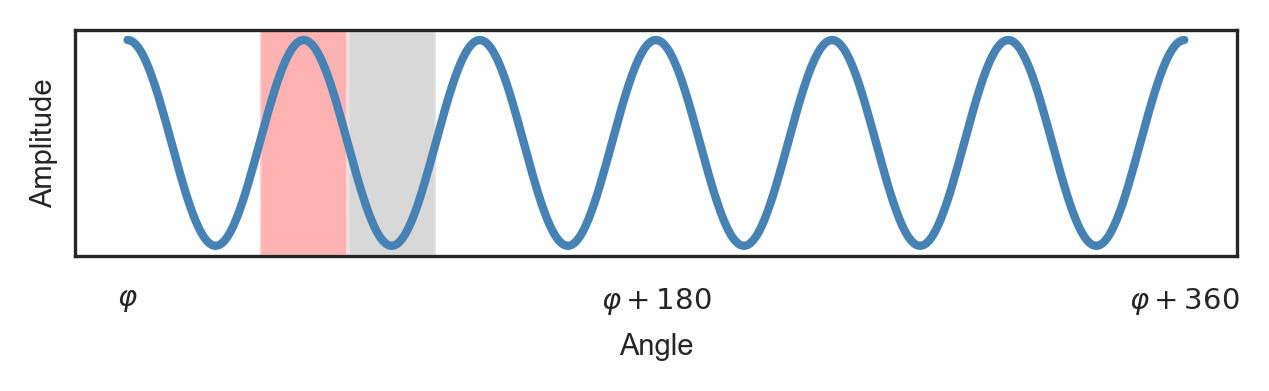

In [85]:
# Define the x-axis values (in radians)
x = np.linspace(0, 2*np.pi, 361)

# Define the amplitudes of the two cosine curves
amp = 0.3

# Generate the two cosine curves
y = amp * np.cos(6*x)

# Plot the two curves
plt.figure(figsize=(5, 1), dpi=300, frameon=False)
plt.plot(x, y,color='steelblue', linewidth=2)

# Set the x-tick labels
xticks = np.linspace(0, 2*np.pi, 3)
xtick_labels = [r'$\varphi$',  r'$\varphi+180$', r'$\varphi+360$']
plt.xticks(xticks, xtick_labels)

# Add a red transparent rectangle shade
shade_min = np.pi/3 - np.pi/12
shade_max = np.pi/3 + np.pi/12
shade1 = plt.axvspan(shade_min, shade_max, facecolor='red', alpha=0.3)

# Add a grey transparent rectangle shade
shade_min = np.pi/3 + np.pi/12
shade_max = np.pi/3 + 3*np.pi/12
shade2 = plt.axvspan(shade_min, shade_max, facecolor='grey', alpha=0.3)

# Remove the y-tick labels
plt.yticks([])

# Set the plot title, labels, and legend
plt.xlabel('Angle')
plt.ylabel('Amplitude')

plt.savefig("/mnt/workdir/DCM/Result/paper/figure2/hexagonal_modulation.pdf", dpi=300, bbox_inches='tight', transparent=True,pad_inches=0)
# Display the plot
plt.show()

ifold 4fold - t-statistic: -0.473, p-value: 0.637,cohensd: -0.055
ifold 5fold - t-statistic: 0.892, p-value: 0.375,cohensd: 0.103
ifold 6fold - t-statistic: 3.117, p-value: 0.003,cohensd: 0.36
ifold 7fold - t-statistic: 1.973, p-value: 0.052,cohensd: 0.228
ifold 8fold - t-statistic: 0.807, p-value: 0.422,cohensd: 0.093


/tmp/ipykernel_199696/2835543292.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='ifold', y="statistic", data=data,alpha=0.5,size=5.5,


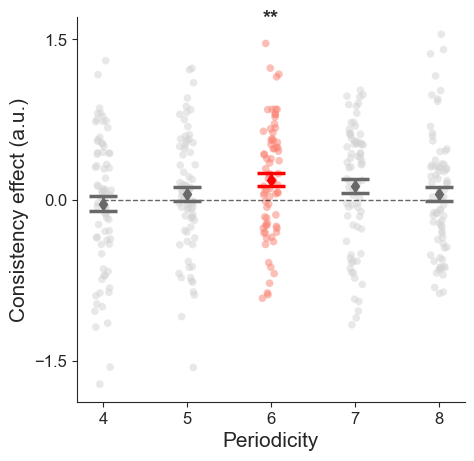

In [6]:
#data = pd.read_csv(r'/mnt/workdir/DCM/Result/analysis/Specificity_to_6/nilearn_cv/sub_stats-z_roi-ec_trial-even.csv')
data = pd.read_csv(r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/cv_test_hexagon_spct/sub_stats-z_roi-ec_trial-even_anat_EC_thr5.csv')
# high performance filter
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
hp_info = participants_data.query(f'(game1_fmri>=0.5)and(game1_acc>0.8)')  # look out
hp_sub = hp_info['Participant_ID'].to_list()
data = data.loc[data['sub_id'].isin(hp_sub)]

fig, ax = plt.subplots(figsize=(5, 5))
sns.stripplot(x='ifold', y="statistic", data=data,alpha=0.5,size=5.5,
            palette=["lightgray", "lightgray", 'salmon', "lightgray", "lightgray"],zorder=1)
x = [0,1,2,3,4]
y = [0]*len(x)
plt.plot(x, y, linestyle='--', color='black',linewidth=1,alpha=0.6)

# Calculate SEM for each group
sem = data.groupby('ifold')['statistic'].sem().values
# Plot error bars
palette=["dimgray", "dimgray", 'red', "dimgray", "dimgray"]
for i, group in enumerate(data.groupby('ifold')):
    plt.plot(i,group[1]['statistic'].mean(), marker='d', markersize=6,color=palette[i],zorder=3)
    ax.errorbar(i, group[1]['statistic'].mean(), yerr=sem[i], fmt='none', color=palette[i], capsize=10,capthick=2.5,linewidth=2,zorder=4)

#plt.ylim([-0.25,0.25])
plt.xticks([0,1,2,3,4],[4,5,6,7,8],size=12)
plt.yticks([-1.5,0,1.5],size=12)

plt.xlabel('Periodicity',size=15)
plt.ylabel('Consistency effect (a.u.)',size=15)

# remove the box lines of the axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

# Add asterisks on top of each bar
vmean = np.max(data['ifold']=='6fold')
# Group the data by 'ifold'
grouped_data = data.groupby('ifold')

# Perform statistical tests for each 'ifold'
for i, group in grouped_data:
    # Extract the statistic values for the current 'ifold' group
    statistics = group['statistic'].values

    # Perform a statistical test (e.g., t-test) against a null hypothesis
    # Here, we assume the null hypothesis that the mean is zero
    t_statistic, p_value = ttest_1samp(statistics, 0)
    cd = cohens_d_onesample(statistics, 0)
    
    # Print the results
    t_statistic = round(t_statistic, 3)
    p_value = round(p_value, 3)
    cd = round(cd, 3)
    print(f"ifold {i} - t-statistic: {t_statistic}, p-value: {p_value}, cohensd: {cd}")

    # Add asterisks on top of each bar based on significance level
    if p_value <= 0.001:
        ax.text(i, vmean + 0.6, '***', ha='center', va='bottom', weight='bold', size=15)
    elif p_value < 0.01:
        ax.text(i, vmean + 0.6, '**', ha='center', va='bottom', weight='bold', size=15)
    elif p_value < 0.05:
        ax.text(i, vmean + 0.6, '*', ha='center', va='bottom', weight='bold', size=15)

ax.tick_params(axis='x', which='both', bottom=True, top=False, direction='out')
ax.tick_params(axis='y', which='both', left=True, right=False, direction='out')
#plt.savefig(r'/mnt/workdir/DCM/Result/paper/figure2/ROI/Specificity_to_6fold.pdf',bbox_inches='tight',pad_inches=0,dpi=300,transparent=True)
plt.show()

In [19]:
# plot align vs misalign

# specify subjects
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
data = participants_data.query('(game1_fmri>=0.5)and(game1_acc>0.8)')
subjects = data['Participant_ID'].to_list()
num = len(subjects)

# set camp
algin_template = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/cv_test_align_spct/Setall/6fold/{}/zmap/m2_alignPhi_even_zmap.nii.gz'
misalgin_template = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/cv_test_align_spct/Setall/6fold/{}/zmap/m2_misalign_even_zmap.nii.gz'

sub_algin_cmaps = [algin_template.format(sub_id) for sub_id in subjects]
sub_misalgin_cmaps = [misalgin_template.format(sub_id) for sub_id in subjects]

# load mask
ec = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/EC/juelich_EC_MNI152NL_prob.nii.gz')
ec = image.binarize_img(ec,5)
#ec = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/hexagon_spct/EC_thr3.1.nii.gz'
#ec = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/EC/func/alignPhi_even_zmap_thr2.3.nii.gz')

# load data
subs_align_mact = np.mean(masking.apply_mask(sub_algin_cmaps, ec), axis=1)
subs_misalign_mact = np.mean(masking.apply_mask(sub_misalgin_cmaps, ec), axis=1)
# demean for each subjects
mean_mact = (subs_align_mact+subs_misalign_mact)/2
subs_align_mact = subs_align_mact-mean_mact
subs_misalign_mact = subs_misalign_mact-mean_mact
subs_mact = np.concatenate((subs_align_mact,subs_misalign_mact),axis=0)
align_data = pd.DataFrame({'Activity':subs_mact,'Group':num*['Align']+num*['Misalign']})

/home/dell/Software/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1065: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


In [20]:
# mean
t_statistic, p_value = ttest_1samp(subs_align_mact, 0)
print("Align's t:", t_statistic)
print("Align's p:", p_value)

t_statistic, p_value = ttest_1samp(subs_misalign_mact, 0)
print("Misalign's t:", t_statistic)
print("Misalign's p:", p_value)

t_statistic, p_value = ttest_rel(subs_align_mact, subs_misalign_mact, alternative="greater")
cd = cohensd(subs_align_mact, subs_misalign_mact)
print("Align vs Misalign's t:", t_statistic)
print("Align vs Misalign's p:", p_value)
print("Align vs Misalign's cohensd:", cd)

Align's t: 10.154076545845863
Align's p: 1.1384911612406258e-15
Misalign's t: -10.154076545845864
Misalign's p: 1.1384911612406095e-15
Align vs Misalign's t: 10.154076545845863
Align vs Misalign's p: 5.692455806203129e-16
Align vs Misalign's cohensd: 2.34498353084647


/tmp/ipykernel_199696/1006808469.py:19: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'blue'}` instead.

  bar = sns.barplot(x=[x_vals[i]], y=[means[i]], alpha=0, color='None', capsize=0.1, errcolor='blue', errwidth=2, error_kw={'ecolor':'blue'})
/tmp/ipykernel_199696/1006808469.py:19: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  bar = sns.barplot(x=[x_vals[i]], y=[means[i]], alpha=0, color='None', capsize=0.1, errcolor='blue', errwidth=2, error_kw={'ecolor':'blue'})
/tmp/ipykernel_199696/1006808469.py:19: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'blue'}` instead.

  bar = sns.barplot(x=[x_vals[i]], y=[means[i]], alpha=0, color='None', capsize=0.1, errcolor='blue', errwidth=2, error_kw={'ecolor':'blue'})
/tmp/ipykernel_199696/1006808469.py:19: FutureWarning: 

Th

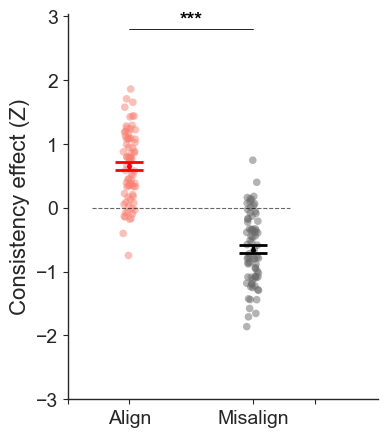

In [22]:
fig, ax = plt.subplots(figsize=(4,5))

# Pre-calculated means and standard errors
means = [subs_align_mact.mean(), subs_misalign_mact.mean()]
errors = [np.std(subs_align_mact, ddof=1) / np.sqrt(len(subs_align_mact)),
          np.std(subs_misalign_mact, ddof=1) / np.sqrt(len(subs_misalign_mact))]

# Configurations for both conditions
colors = [['salmon','red'], ['dimgray','black']]
x_vals = [-0.5, 0.5]
data_sets = [subs_align_mact, subs_misalign_mact]
x_jitters = [np.random.uniform(-0.05, 0.05,size=len(subs_align_mact)) - 0.5,
             np.random.uniform(-0.05, 0.05,size=len(subs_misalign_mact)) + 0.5]

# Plotting for both conditions
ratio = [1,1.02]
marksize = [4,3.7]
for i in range(2):
    bar = sns.barplot(x=[x_vals[i]], y=[means[i]], alpha=0, color='None', capsize=0.1, errcolor='blue', errwidth=2, error_kw={'ecolor':'blue'})
    bar.errorbar(x=[x_vals[i]], y=[means[i]], yerr=[errors[i]], fmt='none', ecolor=colors[i][1], capsize=10,capthick=2, linewidth=2, zorder=2)
    plt.plot(x_vals[i], means[i]*ratio[i], marker='d', markersize=marksize[i], color=colors[i][1], zorder=3)
    sns.scatterplot(x=x_jitters[i], y=data_sets[i], alpha=0.5, color=colors[i][0], s=30, zorder=1,edgecolor='none')

ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Consistency effect (Z)', size=16)

plt.plot([-0.5, 0.5], [2.8, 2.8], color='black', linewidth=0.6)
plt.text(0, 2.8, "***", ha='center', va='bottom', fontsize=14, fontweight='bold', color='black')

x = [-0.8,0.8]
y = [0]*len(x)
plt.plot(x, y, linestyle='--', color='black',linewidth=0.8,alpha=0.6)

plt.xticks([-1, -0.5, 0.5 ,1], ['','Align','Misalign',''], size=14)
plt.yticks([-3, -2, -1 ,0, 1, 2, 3], size=14)

ax.tick_params(axis='x', which='both', bottom=True, top=False, direction='out')
ax.tick_params(axis='y', which='both', left=True, right=False, direction='out')
#plt.savefig(r'/mnt/workdir/DCM/Result/paper/figure2/ROI/cv_6fold_align_misalign.pdf',bbox_inches='tight',pad_inches=0,dpi=300,transparent=True)
plt.show()

In [8]:
# plot align vs misalign 12 bin
def get_subs_act(cmaps,roi):
    subs_mact = []
    for cmap in cmaps:
        # check the file of cmaps exist
        if not os.path.exists(cmap):
            print(f'The cmaps:{cmap} does not exist.')
            subs_mact.append(np.nan)
        else:
            # calculate mean activity in ROI
            sub_mact = np.mean(masking.apply_mask(cmap, roi))
            subs_mact.append(sub_mact)
    return subs_mact


# specify subjects
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
data = participants_data.query('(game1_fmri>=0.5)and(game1_acc>0.8)')
subjects = data['Participant_ID'].to_list()
subjects.sort()
num = len(subjects)

# load mask
#ec = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/EC/juelich_EC_MNI152NL_prob.nii.gz')
#ec = image.binarize_img(ec,5)
#ec = image.load_img(r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/hexagon_spct/EC_thr3.1.nii.gz')
ec = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/EC/func/alignPhi_even_zmap_thr2.3.nii.gz')

# load data
bin12 = pd.DataFrame()
# set camp
template = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/cv_test_align_spct/Setall/6fold/{}/zmap/{}_{}_{}_{}_zmap.nii.gz'

for onset in ['m2']:
    for parity in ['even']:
        for bin in range(1,13,1):
            if bin in range(1,13,2):
                cmaps = [template.format(sub_id,onset,'align',str(bin),parity) for sub_id in subjects]
            elif bin in range(2,13,2):
                cmaps = [template.format(sub_id,onset,'misalign',str(bin),parity) for sub_id in subjects]
            subs_mact = get_subs_act(cmaps,ec)
            bin12 = bin12.append(pd.DataFrame({'Activity':subs_mact,'Direction of mental trajectory':bin,
                                           'hue':'Align' if bin in range(1,13,2) else 'Misalign','sub_id':subjects,
                                           'onset':onset,'parity':parity}))

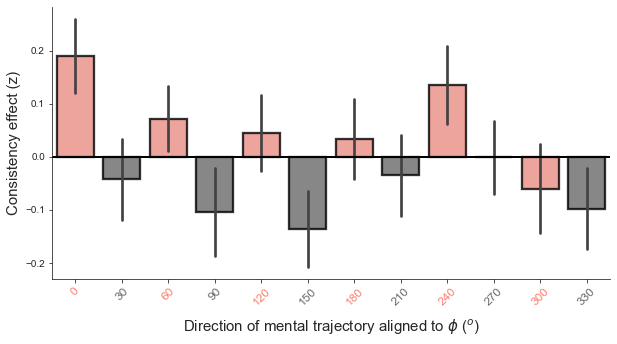

In [16]:
# Demean for acitivity
#bin12['Activity_demean'] = bin12['Activity'] - bin12['Activity'].mean()
bin12['Activity_demean'] = bin12.groupby('sub_id')['Activity'].transform(lambda x: x - x.mean())

fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(data=bin12,x='Direction of mental trajectory',y='Activity_demean',errorbar='se',palette=['salmon','dimgray'],edgecolor='black',linewidth=2.3,alpha=0.8,capsize=0)

x = [-0.5,11.5]
y = [0]*len(x)
plt.plot(x, y, linestyle='-', color='black',linewidth=2,alpha=1)

# remove the box lines of the axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

# add labels
ax.set_xlabel('Direction of mental trajectory aligned to ${\it\phi}$ ($^{o}$)', size=15, labelpad=10)
ax.set_ylabel('Consistency effect (z)',size=15)

# Set custom ticks for the x-axis and y-axis
plt.xlim(-0.5,11.5)
plt.xticks(range(0,12),range(0,360,30),size=12,rotation=45)
xticks = ax.get_xticklabels()
colors = ['salmon', 'dimgray']
for i, label in enumerate(xticks):
    label.set_color(colors[i % len(colors)])
# Add tick lines to the bottom and left spines
ax.tick_params(axis='x', which='both', bottom=True, top=False, direction='out')
ax.tick_params(axis='y', which='both', left=True, right=False, direction='out')
# plt.savefig(r'/mnt/workdir/DCM/Result/paper/figure2/ROI/cv_6fold_align_misalign_12bin_cv_func_EC_roi.pdf',bbox_inches='tight',pad_inches=0,dpi=300,transparent=True)
plt.show()

In [4]:
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
data = participants_data.query('game1_fmri>=0.5')  # look out
data['training_acc'] = (data['train_ap'] + data['train_dp'])/2

mean_accuracy_by_age = data.groupby('Age')['training_acc'].mean()
data['mean_accuracy_by_age'] = data['Age'].map(mean_accuracy_by_age)

subjects = data['Participant_ID'].to_list()

# set cmp template
rsa_zmap = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/grid_rsa_corr_trials/Setall/6fold/' \
           r'{}/rsa/rsa_zscore_img_coarse_6fold.nii.gz'
distance_zmap = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/distance_spct/Setall/6fold/{}/zmap/distance_zmap.nii.gz'
#value_zmap = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/value_spct/Setall/6fold/{}/zmap/value_zmap.nii.gz'


sub_rsa_zmap = [rsa_zmap.format(sub) for sub in subjects]
sub_distance_zmap = [distance_zmap.format(sub) for sub in subjects]
#sub_value_zmap = [value_zmap.format(sub) for sub in subjects]


ec = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/EC/juelich_EC_MNI152NL_prob.nii.gz')
ec = image.binarize_img(ec,5)

mpfc = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/VMPFC/VMPFC_MNI152NL_new.nii.gz')

# extract mean activity of ROI for each subjects
data['hexagon_EC'] =  np.mean(masking.apply_mask(sub_rsa_zmap, ec), axis=1)
# data['alignment_EC'] =  np.mean(masking.apply_mask(sub_alignment_zmap, ec), axis=1)
data['distance_mpfc'] = np.mean(masking.apply_mask(sub_distance_zmap, mpfc), axis=1)

/tmp/ipykernel_152200/3401935355.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['training_acc'] = (data['train_ap'] + data['train_dp'])/2
/tmp/ipykernel_152200/3401935355.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['mean_accuracy_by_age'] = data['Age'].map(mean_accuracy_by_age)
/home/dell/Software/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1065: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with nump

In [5]:
import pingouin as pg
from sklearn.preprocessing import StandardScaler
iv = 'Age'
m = ['hexagon_EC']
dv = 'game1_acc'

# Instantiate the StandardScaler
scaler = StandardScaler()

# fit the scaler to the columns and transform
data[['Age','hexagon_EC','distance_mpfc','game1_acc']] = scaler.fit_transform(data[['Age','hexagon_EC','distance_mpfc','game1_acc']])

# Mediation analysis
mediation_results,indirect_beta_sample = pg.mediation_analysis(data=data, x=iv, m=m, y=dv,seed=42,n_boot=10000,return_dist=True)
print(mediation_results.round(3))

# # # save results
# mediation_results.to_csv(r'/mnt/workdir/DCM/Result/paper/figure3/mediation/Parallel_mediation.csv', index=False)
# np.save(r'/mnt/workdir/DCM/Result/paper/figure3/mediation/Indirect_beta_sample_distance_mPFC.npy', indirect_beta_sample)'s

/tmp/ipykernel_152200/779900559.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[['Age','hexagon_EC','distance_mpfc','game1_acc']] = scaler.fit_transform(data[['Age','hexagon_EC','distance_mpfc','game1_acc']])


             path   coef     se   pval  CI[2.5%]  CI[97.5%]  sig
0  hexagon_EC ~ X  0.158  0.070  0.024     0.021      0.295  Yes
1  Y ~ hexagon_EC  0.313  0.067  0.000     0.181      0.445  Yes
2           Total  0.556  0.059  0.000     0.440      0.671  Yes
3          Direct  0.519  0.057  0.000     0.406      0.632  Yes
4        Indirect  0.036  0.019  0.026     0.007      0.083  Yes
